In [1]:
!pip install sentence_transformers
!pip install transformers
!pip install wordcloud
!pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 1.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [2]:
import warnings
import os
import shutil
import pickle
import re
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from tqdm import tqdm
from transformers import pipeline
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import MiniBatchKMeans
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
full_df = pd.read_csv("/content/drive/MyDrive/metadata.csv")
dfs = []
for year in range(2022, 2023):
    df = pd.read_csv(f"/content/drive/MyDrive/df_deduplicated_{year}.csv", index_col=0)
    df.drop(columns=["minhash"], inplace=True)
    dfs.append(df)
df = pd.concat(dfs)
# Left join on the "cord_uid" column
df = pd.merge(df, full_df[['cord_uid', 'abstract']], on="cord_uid", how="left")
df.dropna(subset=['abstract'], inplace=True) #drop articles with null abstracts
df.to_pickle("prepared_data.pkl")

In [8]:
DEVICE = "cuda"
SENTENCE_ENCODER = SentenceTransformer('all-mpnet-base-v2', device=DEVICE)
embeddings = SENTENCE_ENCODER.encode(df.abstract.tolist(), show_progress_bar=True)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/3023 [00:00<?, ?it/s]

In [9]:
df['Embeddings'] = list(embeddings)

# Step 1 - Load the data

In [ ]:
df = pd.read_pickle("data/prepared_data.pkl")

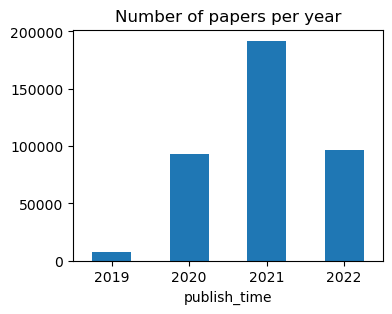

In [ ]:
# Plot the number of papers per year
df.groupby("publish_time").count()["cord_uid"].plot(kind="bar",
    title="Number of papers per year", figsize=(4, 3))
plt.xticks(rotation=0)
plt.show()

# Step 1 - Get sentence embeddings

In [ ]:
#embeddings = np.load("data/embeddings.npy")

In [ ]:
# Concat embeddings to dataframe
#df['Embeddings'] = list(embeddings)

# Step 2 - Topic Modeling for 2020

In [10]:
year = 2022

df_year = df[df.publish_time == year]
print(f"Processing year {year} with {len(df_year)} samples...")

Processing year 2022 with 96709 samples...


In [11]:
# Concat embeddings to dataframe
embedding_df = np.stack(df_year.Embeddings.tolist())
print(embedding_df.shape)

(96709, 768)


In [12]:
# Perform PCA
pca = PCA(n_components=0.90)
embedding_pca = pca.fit_transform(embedding_df)
print(f"Reduced {embedding_df.shape[1]} to {embedding_pca.shape[1]} dimensions.")

Reduced 768 to 219 dimensions.


# MiniBatchKMeans

In [13]:
#use minibatchkmeans to find the optimal number of clusters
# initialize the cluster range and inertia dictionary
kmeans_data = {}
for k in tqdm(range(10, 500, 5)):
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=0, batch_size=1000, max_iter=100)
    kmeans.fit(embedding_pca)
    kmeans_data[k] = dict(
        labels=kmeans.labels_,
        inertia=kmeans.inertia_,
    )

100%|██████████| 98/98 [09:06<00:00,  5.57s/it]


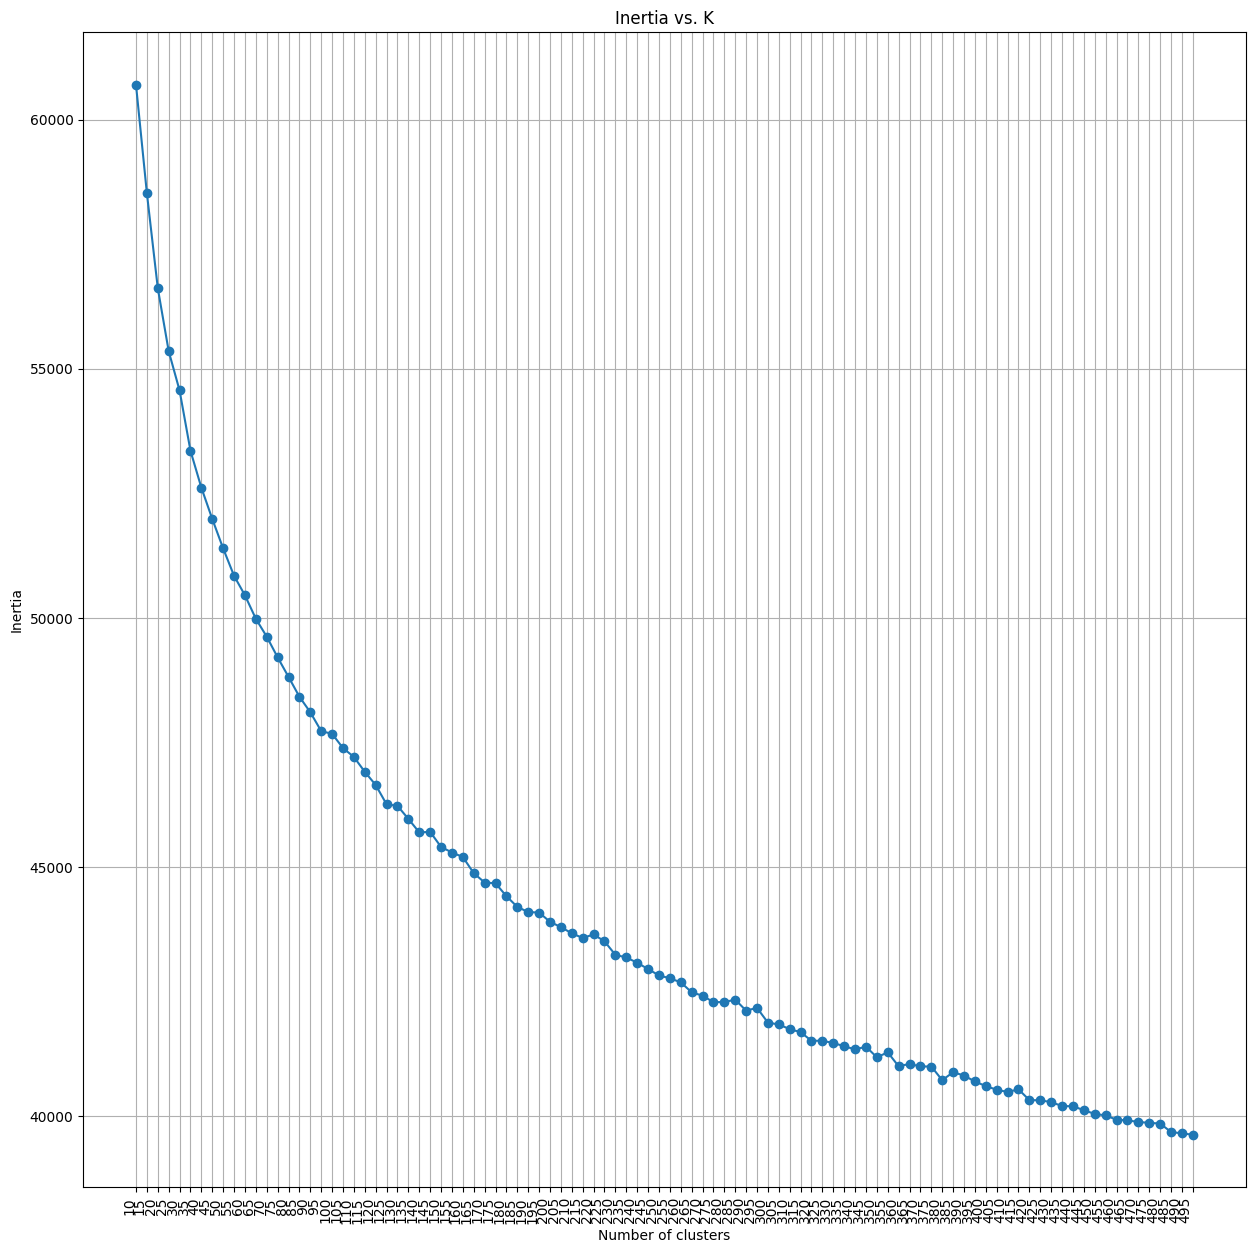

In [14]:
# plot the inertia vs. K
fig, ax = plt.subplots(figsize=(15, 15))
ax.plot(list(kmeans_data.keys()), [km['inertia'] for km in kmeans_data.values()], marker='o')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Inertia')
ax.set_title('Inertia vs. K')
ax.set_xticks(list(kmeans_data.keys()))
ax.grid(True)
plt.xticks(rotation=90, ha='right')
plt.show()

In [15]:
# choose K = 220
k = 220

In [18]:
# save the labels

topic_idx = kmeans_data[k]['labels']
df_year['topics220_idx'] = topic_idx
df_year.to_pickle('/content/drive/MyDrive/topics_220.pkl')
#df_year.to_csv('/content/drive/MyDrive/topics_220.csv')

In [19]:
# tsne
tsne = TSNE(n_components=2, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(embedding_pca)

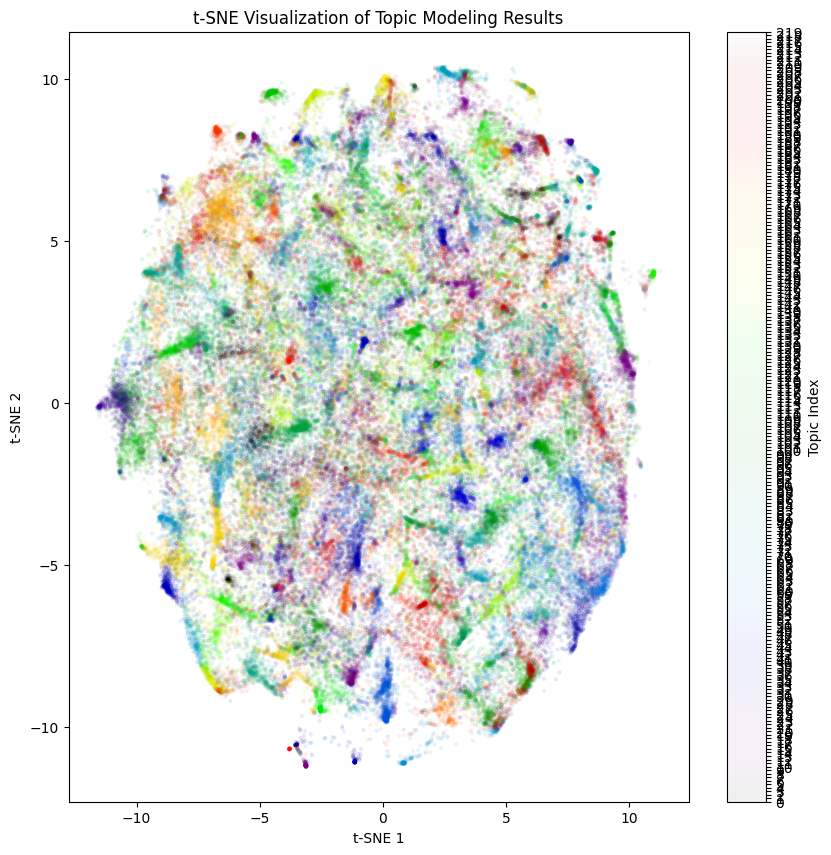

In [20]:
# Plot the T-SNE results
fig, ax = plt.subplots(figsize=(10,10))
scatter = ax.scatter(tsne_results[:,0], tsne_results[:,1], c=df_year.topics220_idx,
                     cmap=plt.cm.nipy_spectral, alpha=0.06, s=5)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("t-SNE Visualization of Topic Modeling Results")
# Add a colorbar for reference
cbar = plt.colorbar(scatter, ticks=range(220))
cbar.set_label('Topic Index')
plt.show()


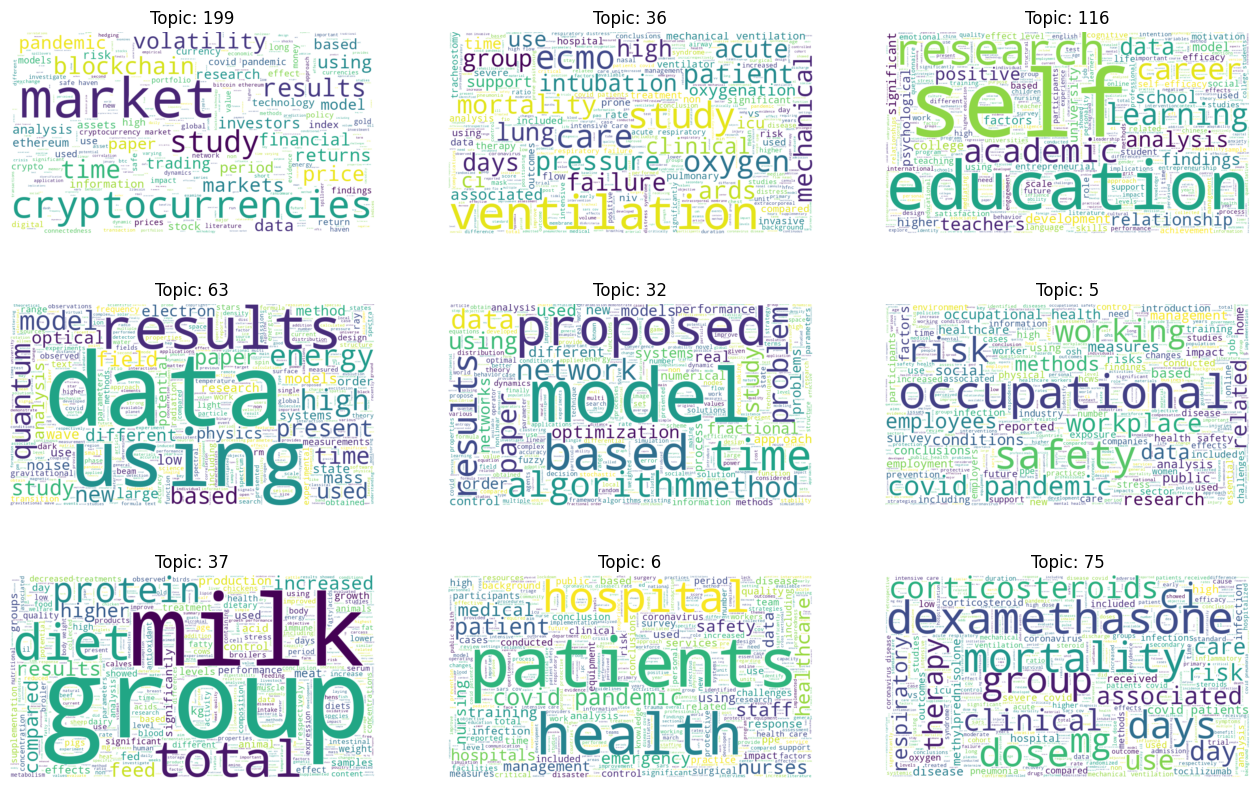

In [22]:
# Generate word cloud for 9 random selected topics
fig, axes = plt.subplots(3, 3, figsize=(16, 10))
axes = axes.flatten()
pattern = re.compile("[^a-zA-Z]")

keywords = []

for ax_index, i in enumerate(np.random.choice(list(range(220)), 9, replace=False)):
    df_topic = df_year[df_year.topics220_idx == i]

    corpus = df_topic.abstract.values
    # Remove non-alphabetical characters
    corpus = [re.sub(pattern, " ", text) for text in corpus]

    # Use CountVectorizer to extract frequencies since it is more flexible
    # Remove words that appear in more than 50% of the documents
    # Also include bigrams
    vectorizer = CountVectorizer(max_df=0.5, stop_words="english",
                                 lowercase=True, ngram_range=(1, 2), max_features=1000)
    vectorizer.fit(corpus)

    # Get the word frequencies dict(string:float)
    # tokens = vectorizer.get_feature_names()
    tokens = vectorizer.get_feature_names_out()
    freqs = vectorizer.transform(corpus).sum(axis=0).A1
    freqs = freqs / freqs.max()
    tokens_to_freqs = dict(zip(tokens, freqs))
    # Sort the dict by values
    tokens_to_freqs = dict(sorted(tokens_to_freqs.items(), key=lambda x: x[1], reverse=True))
    # Get the top 10 keywords
    keywords.append(list(tokens_to_freqs.keys())[:10])

    # Word cloud
    wordcloud = WordCloud(width=900, height=500,
                          background_color="white", max_words=1628,
                          relative_scaling=1, normalize_plurals=False).generate_from_frequencies(tokens_to_freqs)
    #wordcloud.to_file("output/2022/topic_" + str(i) + ".png")
    ax = axes[ax_index]
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.axis("off")
    ax.set_title("Topic: " + str(i))



plt.show()

In [23]:
# Save the keywords to file
with open("output/2022/keywords.json", 'w') as f:
    json.dump(keywords, f)

FileNotFoundError: [Errno 2] No such file or directory: 'output/2022/keywords.json'

# Text Summarization

#### restart the kernal is strongly recommended before run the following code

In [ ]:
# Load the dataframe
BART_SUMMARIZER = pipeline("summarization", model="facebook/bart-large-cnn")

In [ ]:
# Load the dataframe
df_2022 = pd.read_pickle("output/2022/df_year.pkl")
df_2022.columns

Index(['cord_uid', 'title', 'publish_time', 'language', 'abstract',
       'Embeddings', 'topics220_idx'],
      dtype='object')

In [ ]:
# Get the representative articles for each topic

topic_repr_articles = {}

for topic_idx in tqdm(df_2022.topics220_idx.unique()):
    # Get the embeddings for the topic
    df_topic = df_2022[df_2022.topics220_idx == topic_idx]
    # if length of topic < 20, skip
    if len(df_topic) < 20:
        continue
    topic_embeddings = np.stack(df_topic.Embeddings.values)

    # Perform PCA
    pca = PCA(n_components=0.9)
    emb_pca = pca.fit_transform(topic_embeddings)

    # Perform KMeans
    n_repr_articles = 5
    km = KMeans(n_clusters=n_repr_articles, random_state=0)
    km.fit(emb_pca)
    labels = km.labels_
    centroids = km.cluster_centers_

    # Get the representative articles based on the centroids
    repr_articles = []
    for label, centroid in zip(range(n_repr_articles), centroids):
        distances = np.linalg.norm(emb_pca - centroid, axis=1)
        repr_articles.append(df_topic.iloc[np.argmin(distances)].abstract)
    # Save the representative articles
    topic_repr_articles[topic_idx] = repr_articles

 30%|███       | 67/220 [00:43<01:37,  1.56it/s]

In [ ]:
# Save topic_repr_articles
topic_repr_articles = {int(key): value for key, value in topic_repr_articles.items()}
with open("output/2022/topic_repr_articles.json", 'w') as f:
    json.dump(topic_repr_articles, f)

In [ ]:
topic_idx = 0
#print (topic_repr_articles[topic_idx]) in a more readable way with rank
for i in range(5):
    print (topic_repr_articles[topic_idx][i])
    print ("")

Syndromic diagnosis by multiplex nucleic acid amplification tests is the most practical approach to respiratory tract infections since the symptoms are rarely agent‐specific. The aim of this study was to investigate the respiratory viruses in children admitted to a university hospital with acute respiratory tract infection during the last 8 years by a multiplex polymerase chain reaction (PCR) assay. A total of 3162 respiratory samples collected from children between April 2011 and April 2018 tested by a multiplex real‐time PCR assay. Two different commercial assays were used during the study period, "AusDiagnostics/Respiratory Pathogens 12 (AusDiagnostics)" used between April 2011 and December 2015, which changed to "Fast Track Diagnostics/Respiratory Pathogens 21 (Fast Track Diagnostics)" after January 2016 to cover more viruses. Nucleic acid extraction was done by EZ1 Advanced XL platform (QIAGEN). Respiratory pathogens detected in 1857 of the 3162 (58.7%) samples. The most prevalent

In [ ]:
# Load topic_repr_articles and convert keys to int
with open("output/2022/topic_repr_articles.json", 'r') as f:
    topic_repr_articles = json.load(f)
topic_repr_articles = { int(k): v for k, v in topic_repr_articles.items() }

In [ ]:
# Load the summaries
with open("output/2022/summaries.json", 'r') as f:
    topic_summaries = json.load(f)
topic_summaries = { int(k): v for k, v in topic_summaries.items() }

In [ ]:
# Summarize the articles
for topic_idx in tqdm(df_2022.topics220_idx.unique()):
    topic_idx = int(topic_idx)

    # If topic already done, skip
    if topic_idx in topic_summaries or topic_idx not in topic_repr_articles:
        continue

    # Get the representative articles
    repr_articles = topic_repr_articles[topic_idx]
    # Summarize the articles
    summaries = []
    for article in repr_articles:

        # If number of tokens > 1023, discard the texts after that
        # Since the maximum allowed length to BART summarizer is 1024
        tokens = BART_SUMMARIZER.tokenizer.tokenize(article)
        ids = BART_SUMMARIZER.tokenizer.convert_tokens_to_ids(tokens)

        while len(ids) > 1023:
            # If too long, cut half of an article
            article = article[:(len(article) // 2)]
            tokens = BART_SUMMARIZER.tokenizer.tokenize(article)
            ids = BART_SUMMARIZER.tokenizer.convert_tokens_to_ids(tokens)

        # If length is already too short, we use itself as summary
        if len(tokens) < 50:
            sumamry = article
        else:
            summary = BART_SUMMARIZER(article, max_length=50, min_length=10, do_sample=False)[0]['summary_text']

        summaries.append(summary)
    # Save the summaries
    topic_summaries[topic_idx] = summaries

    with open("output/2022/summaries.json", 'w') as f:
        json.dump(topic_summaries, f)

100%|██████████| 220/220 [00:00<00:00, 707627.98it/s]


In [ ]:
# Print the summaries
topic_idx = 51
for i in range(5):
    print (topic_summaries[topic_idx][i])
    print ("")

Cumulative incidence in patients with SAD was up to 5 times higher than general population. Anti-TNF-alpha treatment was associated with more than 3-fold risk of suffering from SARS-CoV-2 infection.

CoVID-19 vaccination in patients with AIIRD is effective using any approved vaccine. Humoral response might be impaired depending on the individual immunosuppressive medication. Risk of non-response is highest under rituximab

Disease-modifying therapies (DMTs) used to treat multiple sclerosis (MS) alter the immune system and therefore increase the risk of infection. There is growing concern about the impact of COVID-19 on patients with

Multiple sclerosis disease modifying therapies (DMTs) might affect immune responses to SARS-CoV-2 exposure or vaccination in patients with MS. We evaluated the effect of DMTs on humoral and cell-mediated immune responses

The COVID-19 pandemic has brought challenges for people with rheumatic disease. There are concerns about higher risks of infection with 